In [1]:
import pandas as pd 
import numpy as np
import csv
import torch
from builtins import open, bytes
import gensim
from sklearn.metrics import silhouette_score
from gensim.utils import simple_preprocess
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim.corpora as corpora
nltk.download('stopwords')
from deep_translator import GoogleTranslator
from langdetect import detect
import seaborn as sns
from recordlinkage.standardise import clean
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from sklearn.preprocessing import StandardScaler

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Setup**

In [2]:
# initialize the sentiment analyzer 
sid = SentimentIntensityAnalyzer()

# create the function to calculate the sentiment score, on a scale of [-1,1], as 1 is most positive 
def sentiment_score_nltk(text):
    return sid.polarity_scores(text)['compound']

In [3]:
# readin all countries files 
china = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_translated.csv')
iran = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_translated.csv')
nk = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_translated.csv')
russia = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_translated.csv')

# create bert version of files 
china_bert = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_translated.csv')
iran_bert = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_translated.csv')
nk_bert = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_translated.csv')
russia_bert = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_translated.csv')


In [4]:
# Map month names to numbers, assuming 'month' contains short month names
def date_convert(china):    
    month_map = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
        'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }

    china['month'] = china['month'].map(month_map)
    china['year'] = china['year'].astype(int).astype(str)

    # Create 'year_month' column
    # china['year_month'] = china['year']
    # + '-' + china['month'] 

    # remove uncessary columns
    china.drop(columns=['day','Unnamed: 0'],inplace=True)
    return china

In [5]:
# Load a pre-trained BERT model fine-tuned for sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt', truncation=True, max_length=512)
    output = model(tokens)[0]
    sentiment = torch.argmax(output, dim=-1).item() + 1
    return sentiment

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# convert date value of each file and store everything in the all_countries.csv 

# Calculate the Sentiment Score for each tweets using NLTK  
china['sentiment'] = china['translated'].apply(sentiment_score_nltk)
iran['sentiment'] = iran['translated'].apply(sentiment_score_nltk)
nk['sentiment'] = nk['translated'].apply(sentiment_score_nltk)
russia['sentiment'] = russia['translated'].apply(sentiment_score_nltk)

china = date_convert(china)
iran = date_convert(iran)
russia = date_convert(russia)
nk = date_convert(nk)

# countries = pd.concat([china,iran,nk,russia],axis=0)
# countries.drop(columns=['ulr','Unnamed: 0.1'])
# countries.sort_values('year')
# countries.to_csv("/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/all_countries.csv")

In [91]:
# convert date value of each file and store everything in the all_countries.csv 

# Apply the bert sentiment_score function to the 'translated' column
china_bert['sentiment_bt'] = china_bert['translated'].apply(lambda x: sentiment_score(x))
nk_bert['sentiment_bt'] = nk_bert['translated'].apply(lambda x: sentiment_score(x))
russia_bert['sentiment_bt'] = russia_bert['translated'].apply(lambda x: sentiment_score(x))
iran_bert['sentiment_bt'] = iran_bert['translated'].apply(lambda x: sentiment_score(x))

# countries_bert = pd.concat([china_bert,nk_bert,russia_bert,iran_bert],axis=0)
# countries_bert.drop(columns=['ulr','Unnamed: 0.1'])
# countries_bert.sort_values('year')
# countries_bert.to_csv("/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/all_countries_bert.csv")

In [264]:
countries_bert = pd.read_csv("/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/all_countries_bert.csv")
countries_bert.drop(columns=["Unnamed: 0.1","ulr","Unnamed: 0"],inplace=True)
countries = pd.read_csv("/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/all_countries.csv")
countries.drop(columns=['Unnamed: 0.1'],inplace=True)

In [3]:
def plot_percentage_negative_tweets(country, data, threshold, color):
    """
    Plots the time-series percentage of negative tweets for a specific country.
    A tweet is considered negative if its sentiment_bert value is less than or equal to the threshold.
    
    Args:
    country (str): The name of the country to plot.
    data (DataFrame): The DataFrame containing the sentiment data.
    threshold (int): The maximum sentiment_bert value that classifies a tweet as negative.
    
    Returns:
    None, but displays a matplotlib plot.
    """
    # Filter the data for the specified country
    country_data = data[data['country'].str.lower() == country.lower()]
    
    country_data['date'] = pd.to_datetime(country_data['year'].astype(str) + '-' + country_data['month'].astype(str) + '-01')

    # Create a column to identify negative tweets based on the threshold
    country_data['is_negative'] = country_data['sentiment_bt'] <= threshold
    
    # Group by date and calculate the percentage of negative tweets
    country_grouped = country_data.groupby('date')['is_negative'].mean() * 100
    
    # Plotting the time series data
    plt.figure(figsize=(12, 6))
    plt.plot(country_grouped.index, country_grouped, marker='o', linestyle='-', color=color)
    plt.title(f'Percentage of Negative Tweets Over Time for {country.capitalize()} (Threshold: ≤{threshold})')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Negative Tweets')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [187]:
def plot_country_sentiment(country_name, data, color):
    # Filter data from 2018 to 2023
    filtered_data = data

    # Mark tweets as negative if sentiment is less than -0.05
    filtered_data['is_negative'] = filtered_data['sentiment'] < -0.05

    # Group by country, year, and month, then calculate the percentage of negative tweets
    grouped_data = filtered_data.groupby(['country', 'year']).agg(
        total_tweets=pd.NamedAgg(column="sentiment", aggfunc="count"),
        negative_tweets=pd.NamedAgg(column="is_negative", aggfunc="sum")
    )
    grouped_data['percentage_negative'] = (grouped_data['negative_tweets'] / grouped_data['total_tweets']) * 100

    # Reset index to make 'year' and 'month' columns usable
    grouped_data.reset_index(inplace=True)
    # Filter data for the specific country
    country_data = grouped_data[grouped_data['country'] == country_name]

    # Create a 'date' column from 'year' and 'month'
    country_data['date'] = pd.to_datetime(country_data['year'].astype(str) .astype(str) )

    # Set 'date' as the new index
    country_data.set_index('date', inplace=True)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(country_data.index, country_data['percentage_negative'], marker='o', linestyle='-', color=color)
    plt.title(f'Feburary Percentage of Negative Tweets for {country_name} (2018-2023)', fontweight='bold', fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Percentage of Negative Tweets', fontsize=16)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

## **Visualization**

### **Gallup Data**

In [265]:
# Example usage of the function
countries['year'] = countries['year'].astype(int)  # Convert 'year' to integer
countries_2 = countries[countries['month']==2]

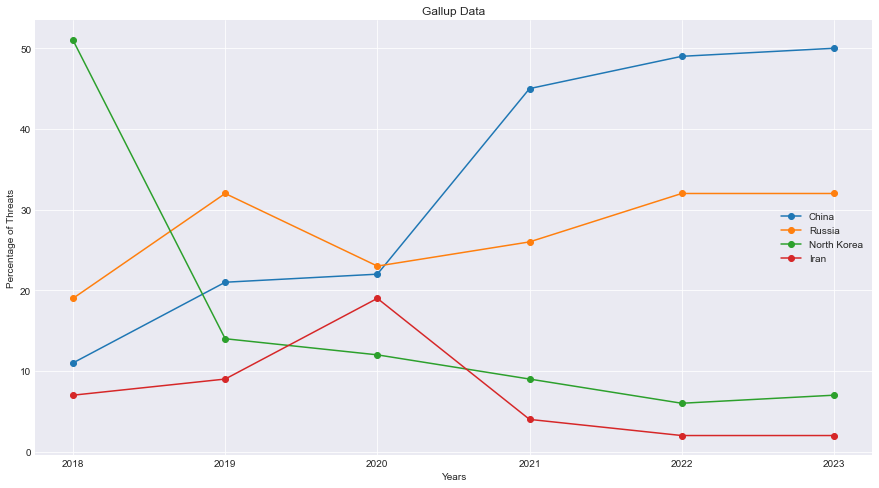

In [203]:
gallup3 = pd.read_csv("/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/gallup_cleaned.csv")
# Setting the style
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,2],marker='o', label='China')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,3],marker='o', label='Russia')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,4],marker='o', label='North Korea')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,5],marker='o', label='Iran')

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.set_title('Gallup Data')
ax.legend()

In [55]:
# Function to create a plot for a given country
def plot_country_data(data, country_index, country_name, color):
    # Setting the style
    plt.style.use('seaborn-darkgrid')

    # Create a color palette
    palette = plt.get_cmap('tab10')

    # Creating the plot
    plt.figure(figsize=(8, 6))
    plt.plot(data.iloc[4:, 1], data.iloc[4:, country_index], marker='o', color=color, label=country_name)
    plt.xlabel('Years', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=15)  # Increase tick font size
    plt.ylabel('Percentage of Threats', fontsize=16)
    plt.title(f'Perception of Threat from {country_name} (Gallup)',fontsize=16, fontweight='bold')
    plt.legend(fontsize = 14)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


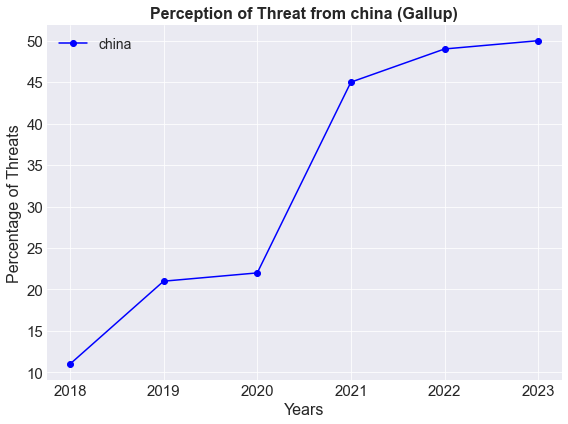

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['is_negative'] = filtered_data['sentiment'] < -0.05
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) .astype(str) )


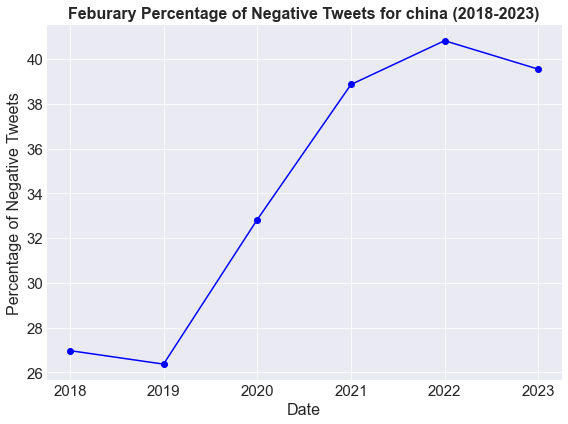

In [193]:
plot_country_data(gallup3, 2, 'china',"blue")
plot_country_sentiment('china', countries_2,"blue")

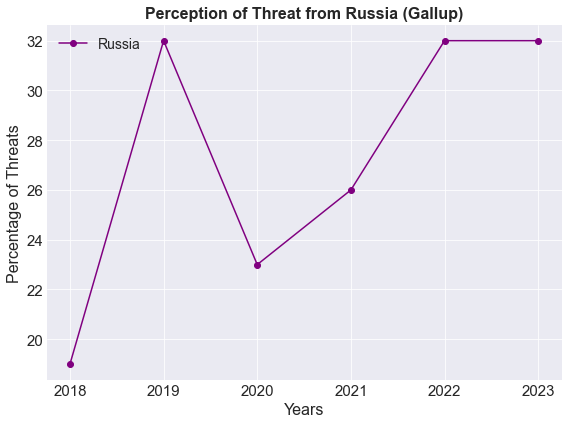

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['is_negative'] = filtered_data['sentiment'] < -0.05
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) .astype(str) )


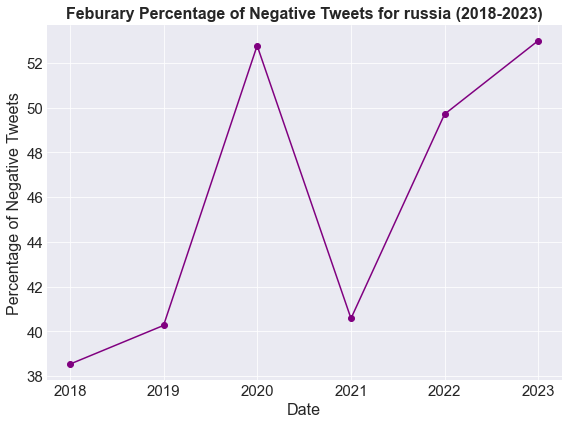

In [188]:
plot_country_data(gallup3, 3, 'Russia',"purple")
plot_country_sentiment('russia', countries_2,"purple")

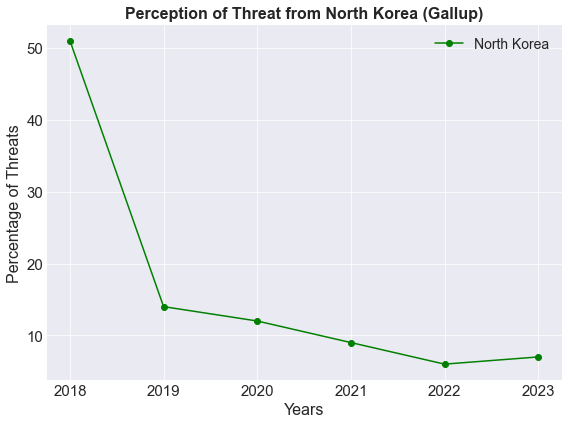

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['is_negative'] = filtered_data['sentiment'] < -0.05
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) .astype(str) )


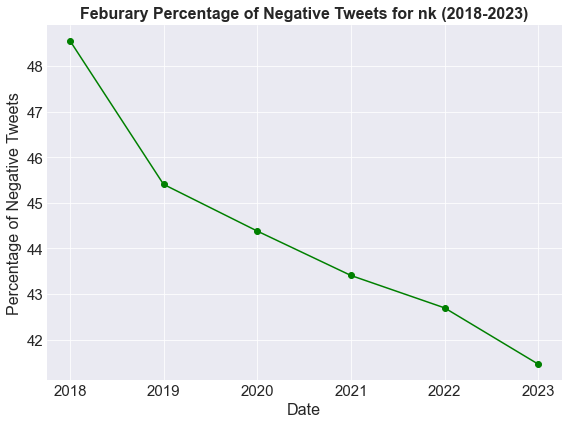

In [266]:
plot_country_data(gallup3, 4, 'North Korea',"green")
plot_country_sentiment('nk', countries_2,"green")

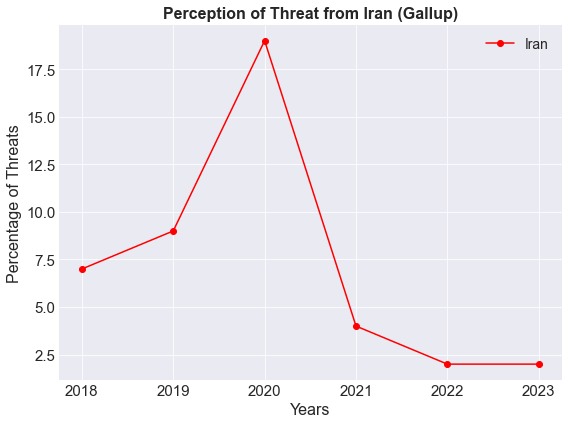

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['is_negative'] = filtered_data['sentiment'] < -0.05
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_42995/1952696051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) .astype(str) )


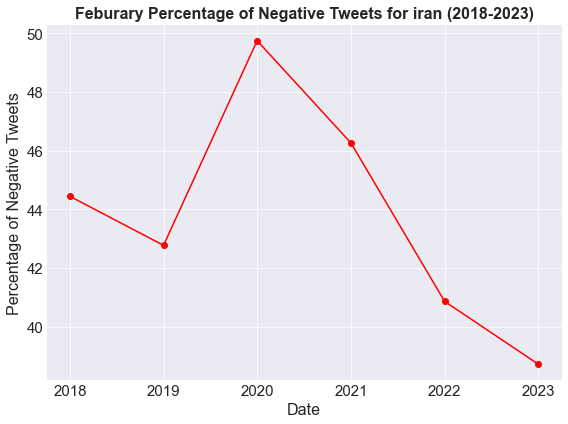

In [190]:
plot_country_data(gallup3, 5, 'Iran',"red")
plot_country_sentiment('iran', countries_2,"red")

### **Monthly Sentiments**

In [53]:
# Example usage of the function
countries['year'] = countries['year'].astype(int)  # Convert 'year' to integer
countries_2 = countries[countries['month']==2]

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_1086/4277103801.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) + '-' + country_data['month'].astype(str) + '-01')


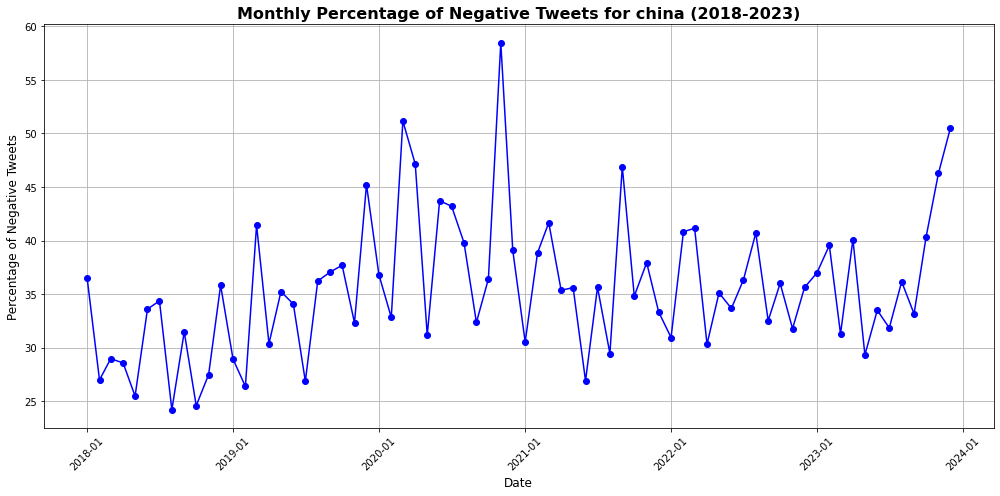

In [49]:
plot_country_sentiment('china', countries,"blue")

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_1086/4277103801.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) + '-' + country_data['month'].astype(str) + '-01')


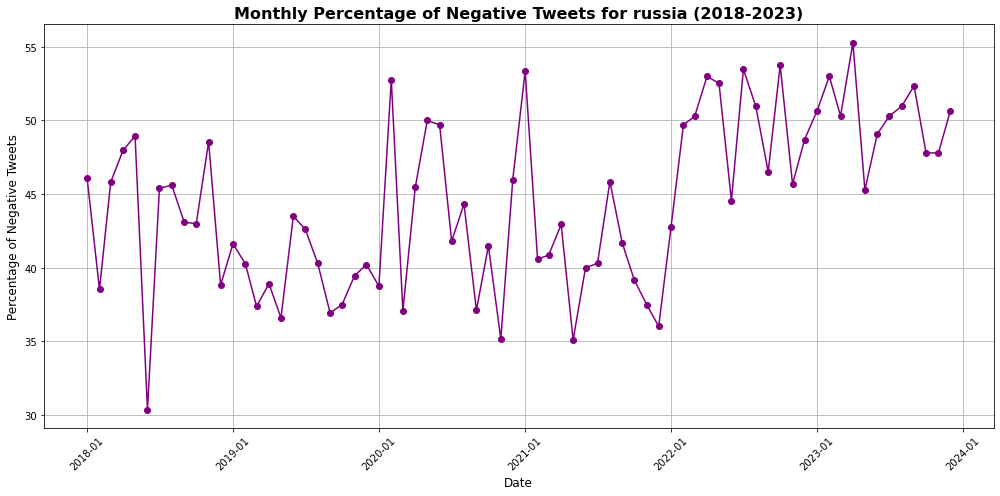

In [50]:
plot_country_sentiment('russia', countries,"purple")

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_1086/4277103801.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) + '-' + country_data['month'].astype(str) + '-01')


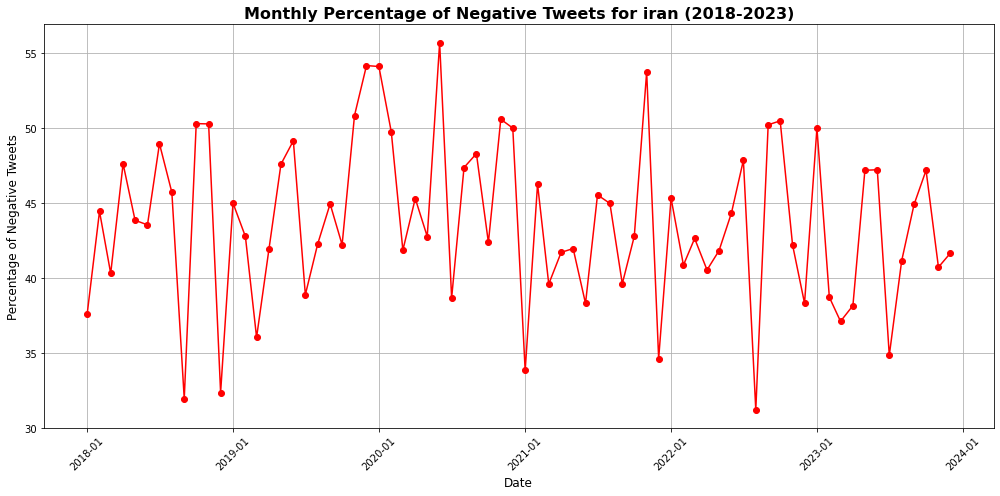

In [51]:
plot_country_sentiment('iran', countries,"red")

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_1086/4277103801.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['year'].astype(str) + '-' + country_data['month'].astype(str) + '-01')


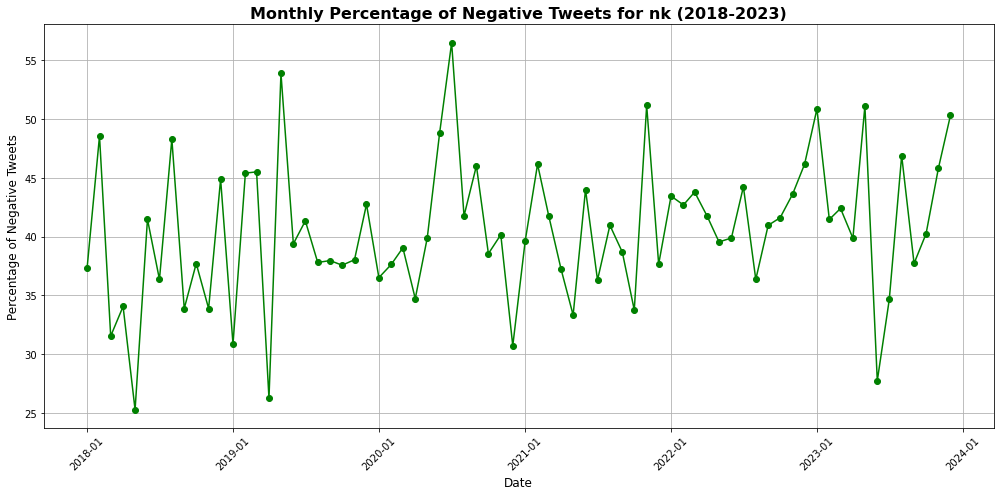

In [52]:
plot_country_sentiment('nk', countries,"green")

## **Topic Modeling**

### **Functions**

In [17]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd

# Function to load data (modify path as needed)
def load_data(file_path):
    return pd.read_csv(file_path)

# Function to create embeddings
def create_embeddings(texts, model, tokenizer):
    # Tokenize and encode sequences in the batch
    encoded_batch = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # Compute token embeddings
    with torch.no_grad():
        outputs = model(**encoded_batch)
        # Pull the tensor out of the GPU if necessary and convert to numpy for standard processing
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    
    return embeddings

# Main function to process and analyze data
def analyze_tweets(data):
    # Load data
    df = data
        
    # Load pre-trained model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
    model = BertModel.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
    
    # Select a manageable subset of data for demonstration
    sample_texts = df['translated'].tolist()
    
    # Generate embeddings
    embeddings = create_embeddings(sample_texts, model, tokenizer)
    
    # Here you can perform further analysis, like clustering, to identify topics
    print("Embeddings shape:", embeddings.shape)
    return embeddings

# Main function to evaluate cluster effectiveness
def evaluate_clusters(embeddings, clusters):
    # Silhouette Score
    silhouette_avg = silhouette_score(embeddings, clusters)
    print(f"Silhouette Score: {silhouette_avg}")


# Print representative documents for each cluster
def print_representative_docs(texts, clusters, n_docs=3):
    # Create a dictionary to hold texts for each cluster based on actual cluster labels found
    cluster_texts = {}
    for text, cluster in zip(texts, clusters):
        if cluster in cluster_texts:
            cluster_texts[cluster].append(text)
        else:
            cluster_texts[cluster] = [text]
    
    for cluster, docs in cluster_texts.items():
        print(f"\nCluster {cluster}:")
        # Print the first 'n_docs' documents from the cluster
        for doc in docs[:n_docs]:
            print(f" - {doc}")

# Check for the optimial number of clusters
def create_sil_chart(embeddings):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(embeddings)

    # Applying PCA for dimensionality reduction for visualization purposes
    pca = PCA(2)
    X_pca = pca.fit_transform(X_scaled)

    # Calculate WCSS and Silhouette scores for a range of number of clusters
    wcss = []
    silhouette_scores = []
    K_range = range(2, 20)  # Test from 2 to 10 clusters

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Plotting the Silhouette Scores graph
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 1, 1)
    plt.plot(K_range, wcss, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method For Optimal k')
    plt.tight_layout()
    plt.show()

### **China**

In [18]:
china = countries_bert[countries_bert['country']=='china']
china_19 = china[(china['year']==2019) & (china['month'].isin([11,12]))]
china_20 = china[(countries_bert['year']==2020) & (china['month'].isin([1,2,3]))]
china_aft = pd.concat([china_19, china_20], axis=0)
china_aft = china_aft[china_aft['sentiment_bt'].isin([1,2,3])]

china_bef = china[(china['year']==2019) & (china['month'].isin([6,7,8,9,10]))]
china_bef = china_bef[china_bef['sentiment_bt'].isin([1,2,3])]

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_1086/3563064522.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  china_20 = china[(countries_bert['year']==2020) & (china['month'].isin([1,2,3]))]


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

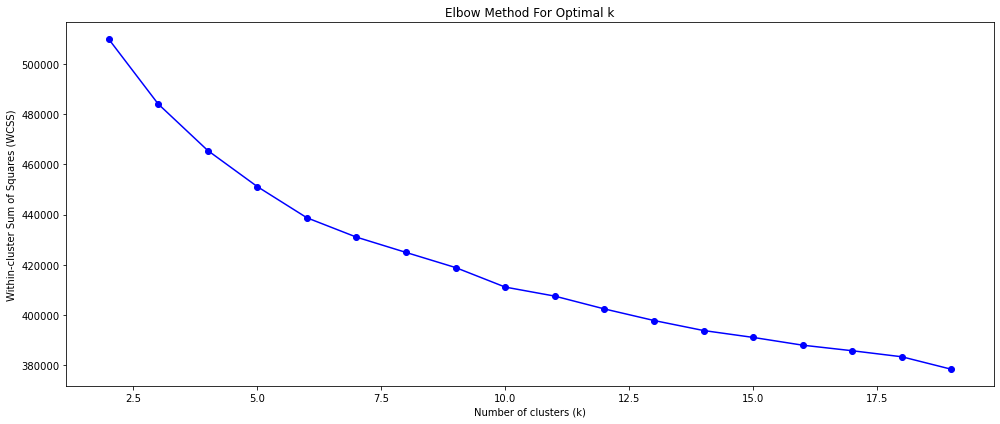

In [22]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(china_aft)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [24]:
# Clustering with K-means
kmeans = KMeans(n_clusters=8, random_state=0)  # Assume we want 3 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(china_aft['translated'].tolist(), clusters)


Cluster 0:
 - fellas racist rail chinese government putting muslims concentration camps
 - say hate china dont mean hate chinese people mean hate fact chinese government killing torturing millions brothers sisters unprovoked
 - fact chinese government literally forcing people religion putting camps western media pretty much silent

Cluster 5:
 - cropcircle ufo right mind could believe 2012 crop picture made using rope boards unseen vandals near busy roadfake news medialying people like chinacnn cctv 
 - reason jack stepped leading alibaba gt longer useful chinese government alibaba tbh chinese companies company controlled tyrannical chinese government 
 - youve wondering source claims chinese government plans write quran chinese state media

Cluster 1:
 - taiwan goes polls jan 11 elect next presidentamidst grand us china conflict election bring parties concerned referendum taiwans future relationship ccppremiere 730pm est  
 - china jungkooks land wbk bts twt
 - even cash tracked chin

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (798, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

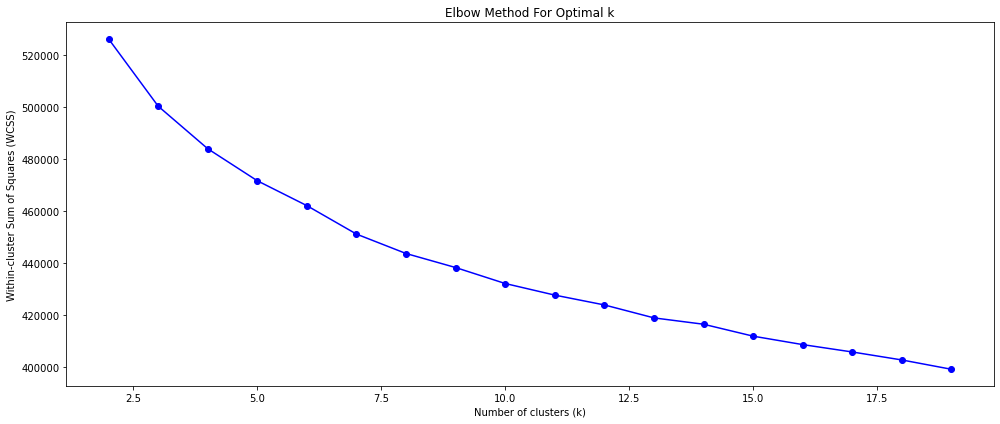

In [25]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(china_bef)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [241]:
# Clustering with K-means
kmeans = KMeans(n_clusters=10, random_state=0)  # Assume we want 3 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(china_bef['translated'].tolist(), clusters)

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 0:
 - Henikusman's uyokback makes sense but I'm not sure the Jae regime will be able to save this nation from China's trap
 - iamjuanderful1 cnn garytuchmancnn think china lose america far greatest consumer market world cant sell junk us lose big chunk economyamerica buy stuff nation china doesnt consumerism like america
 - taro taylor notosans s2k 70 incoming foreign captial china comes thru hk ccp would want rock boat unless really really really towhen pla rolls 1c2s wouldnt effectively dead itll officially dead

Cluster 2:
 - realdonaldtrump china says trump lying restarting trade talks  via youtube
 - chinas tariffs strike another blow agricultural stocks 
 - im china sankai paulo sp

Cluster 1:
 - usa made chinarealdonaldtrump
 - well couple stoppages ufc china looks like horrifically boring im currently chinese time zone still didnt even bother watch may go least viewed card ufc history
 - obama talked china ethical trump something 

Cluster 3:
 - tariff war wit china go

### **Russia**

In [244]:
russia_18 = countries[(countries['country']=="russia") & (countries['year'].isin([2018])) & (countries['month'] == 6)]

russia_19 = countries[(countries['country']=="russia") & (countries['year'].isin([2019])) & (countries['month'].isin([1, 2]))]

russia_22 = countries[(countries['country']=="russia") & (countries['year']== 2022) & (countries['month'].isin([3,4,5,6,7]))]
russia_aft = russia_22

russia_21 = countries[(countries['country']=="russia") & (countries['year'] == 2021) & (countries['month'].isin([12,11,10,9]))]
russia_22 = countries[(countries['country']=="russia") & (countries['year']== 2022) & (countries['month'] == 1)]
russia_bef = pd.concat([russia_21,russia_22], axis=0)

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (375, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

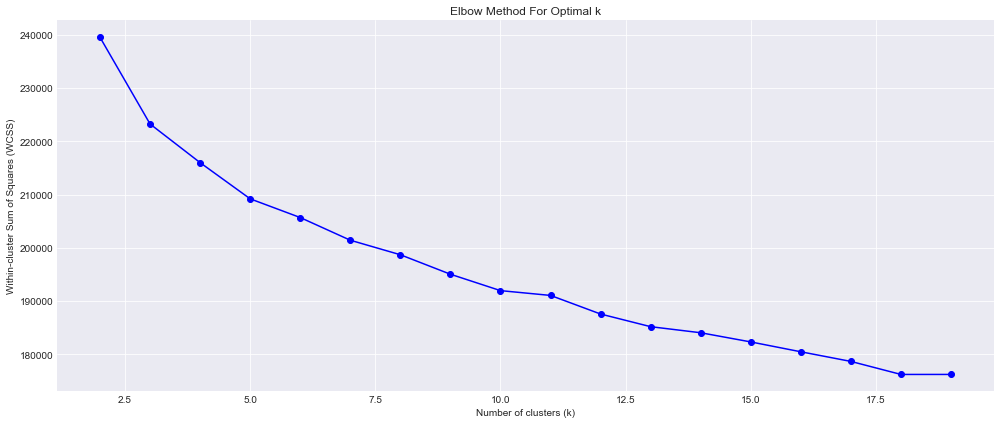

In [245]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(russia_19)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [246]:
# Clustering with K-means
kmeans = KMeans(n_clusters=10, random_state=0)  # Assume we want 8 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(russia_19['translated'].tolist(), clusters)


Cluster 1:
 - russia threat greatest threat america greatest threat america china dr sebgorka 
 - russia set new world record wheat exports 44 million tons previous achievement dated back 1981 belonged us 439 million tons  
 - eritrea u20 soccer team wins 4 1 russia friendly match asmara eritreas four goals started sabr yemane bursted russias defense scored measured brilliant goal bbcsport mls fifacom africa 

Cluster 8:
 - woman says evidence trump russia collusion forcibly detained agents moscow asked us asylum got crickets trump admin wonder  
 - trump knew advance emails hacked russia would leaked hurt hillary according michael cohen 
 - breaking trump created major security threat overruling fbi cia give kushner security clearance despite concerns corrupting influence foreign business entanglements israel united arab emirates russia 

Cluster 2:
 - abraham lincoln america never destroyed outside falter lose freedoms destroyed ourselvesour biggest threat isis china russia within w

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (168, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

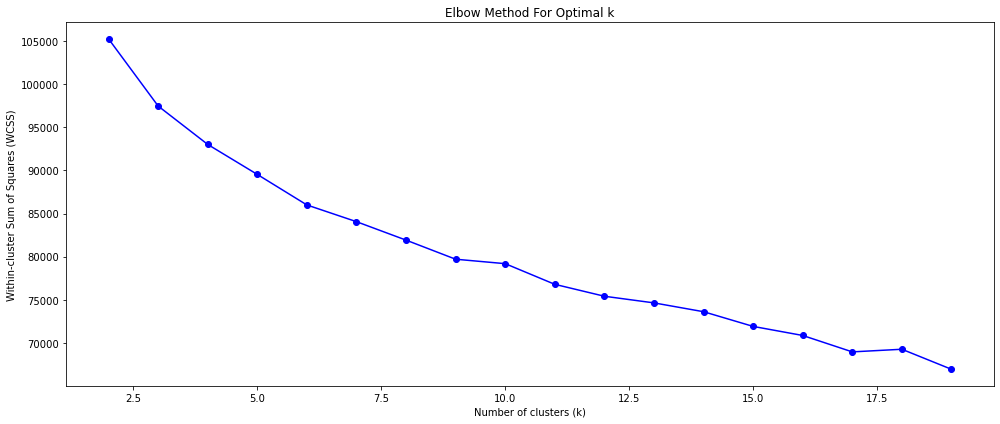

In [36]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(russia_18)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [38]:
# Clustering with K-means
kmeans = KMeans(n_clusters=8, random_state=0)  # Assume we want 8 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(russia_18['translated'].tolist(), clusters)


Cluster 5:
 - ended donald trump president us help msm russia hacking wikileaks james comey russia trump conspiracies trump opening pandoras box hate testament sane humane americans hillary popular vote 3m votes 
 - forceddisplacement daraa civilians leave hometowns running assad regime russia bombing dara south syriajune 22 2018 reutersalaa al faqir 
 - russian bots really maxine waters hashtag encouraging civil war stupid people go yeah duh yeah rt racismrussia already hacked election dont let hack brainthe civil war threats coming russia dont engage

Cluster 2:
 - world cup 2018 vice president steventalevski proudly wearing keilor wolves top russia week showcasing world well done stevenoneclubonefamily wolves socceroos 
 - obamas russia expert giant gap trumps policies friendship putin 
 - yes including russia anchor babies investing properties merit needed money dirtier better 

Cluster 7:
 - jamesfourm ericgarland gametheorytoday techcrunch airbnb houzz oliver jung german based t

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Russia before Ukra

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (856, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

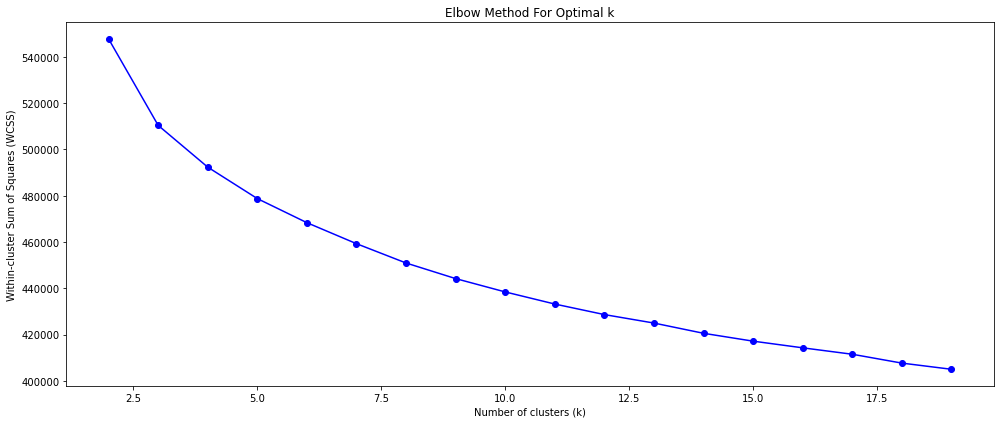

In [40]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(russia_bef)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [43]:
# Clustering with K-means
kmeans = KMeans(n_clusters=7, random_state=0)  
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(russia_bef['translated'].tolist(), clusters)


Cluster 5:
 - true censoring yiff russia 
 - heres incomplete chart influence operations part cognitive warfare campaign waged us domestic terrorists support russia foreign governmentsfive white fascist men behind allflynn prince stone thiel bannonarrest 
 - russia tightens internet censorship fines banned content  

Cluster 4:
 - bravo senatorshaheen senrobportman clearstrong message support ukraine russias ongoing aggression must act pick pieces latercepa atlanticcouncil 
 - year whenever mentioned fact russia behind lot got ruthlessly trolled left right blueanon kremlin simultaneously support far right far left long competition one another 
 - ukraine turkeyit reported ukraine begun produce assemble turkey baykartech made tb2 ucavs militarythese ucavs enhance ukraines capabilities defend borders possible conflict russia nato 

Cluster 0:
 - dear rncfor support trumpf paying defense proves russia hack 
 - disrespecting prophet muhammad freedom expression putinmfa russia 
 - dec 24 1

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Russia aft ukra

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (916, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

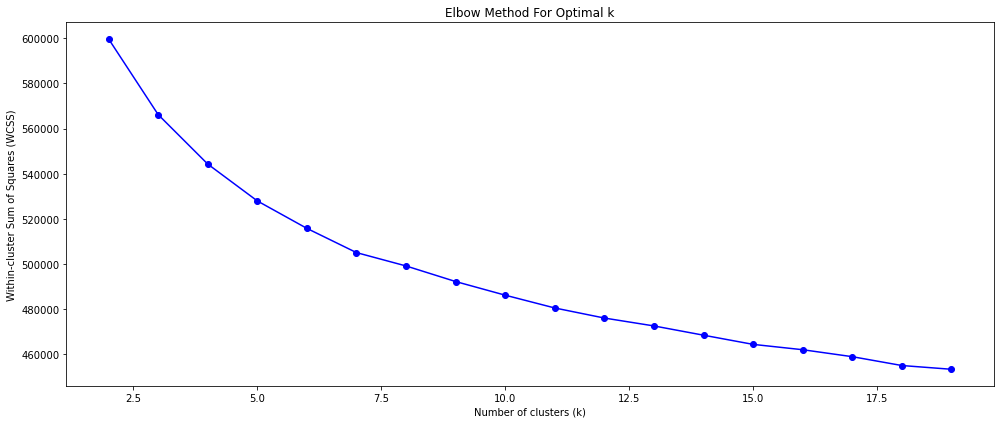

In [44]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(russia_aft)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [45]:
# Clustering with K-means
kmeans = KMeans(n_clusters=7, random_state=0)  
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(russia_aft['translated'].tolist(), clusters)


Cluster 0:
 - students ural federal university massively leave lecture dangers ukraine nato 
 - ft european energy crisis continues brussels said european buyers russian gas would breach sanctions accepted kremlin demands payment roubles companies preparing accept russias demands 
 - europes economic downturn isnt covid wasnt russia instead last six months growing growth scare us japan china 2018globally synchronized euro 5 

Cluster 4:
 - angelina jolie lviv railway stationukraine ukrainewar ukrainerussianwar ukraine angelinajolie russia russiaukrainewar russianwarcrimes 
 - angelina jolie met children affected missile strike kramatorskukraine ukrainerussianwar ukrainerussiawar ukrainian russia russiaukrainewar russianwarcrimes russianukrainianwar
 - russias foreign ministry spokesperson maria zakharova hit pentagon spokesperson john kirby saturday got emotional talking countrys invasion ukrainecompose least act like represent military

Cluster 6:
 - ukrainian nazis battalions wiped 

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### **Iran**

In [249]:
iran_19 = countries[(countries['country']=="iran") & (countries['year'].isin([2019])) & (countries['month'].isin([12]))]
iran_20 = countries[(countries['country']=="iran") & (countries['year'].isin([2020])) & (countries['month'].isin([1,2,3,4]))]
iran_protest = pd.concat([iran_19,iran_20],axis=0)

iran_bef = countries[(countries['country']=="iran") & (countries['year'].isin([2019])) & (countries['month'].isin([6,7,8,9,10]))]

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (1001, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

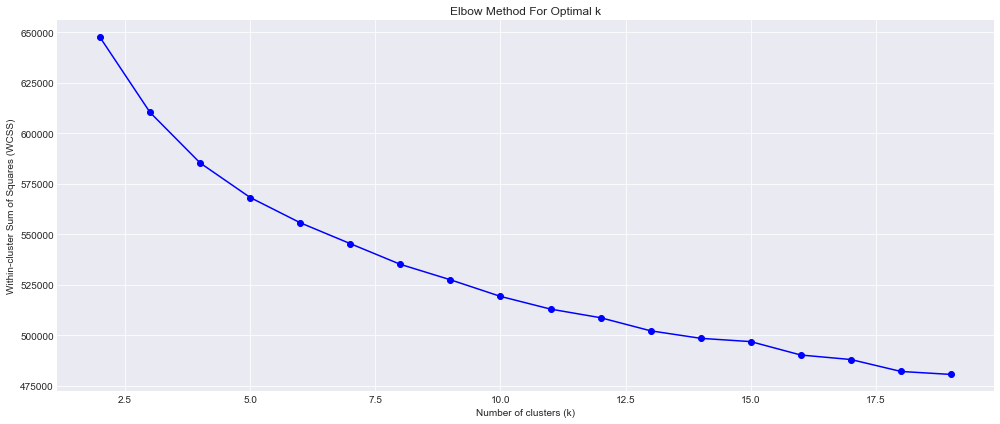

In [250]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(iran_protest)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [251]:
# Clustering with K-means
kmeans = KMeans(n_clusters=10, random_state=0)  # Assume we want 3 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(iran_protest['translated'].tolist(), clusters)

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 8:
 - loud clear message sent iran yesterday 5 precision strikes authorized realdonaldtrump secpompeo response 1 iranian rocket killed 1 us contractoriranian death toll 25 amp risinggodblessamerica godblesspresidenttrump bestpresidentever45 
 - iran second biggest jewish population islamic world unlike marks recent fave saudi arabia iran actual active synagogues mainstream reporters think tanks take markdubowitz seriously expert iran truly remarkable
 - secpompeo un antonioguterres thank mr secretaryyou utmost respect iranian peoplethe iranian people terrorized recently gt1500 slaughtered militia inside irannow time get ones responsible death thousands 

Cluster 1:
 - city ardebil iranthe municipality agents assaulted amp broke nose old street hawker selling goods take care familythey also confiscated belongingsrewards4justice 
 - irans nuclear ambitionsthe cia clever cyber war program shut downbut things never go according planespionage accidentalspy iran cia thriller kindlet

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (890, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

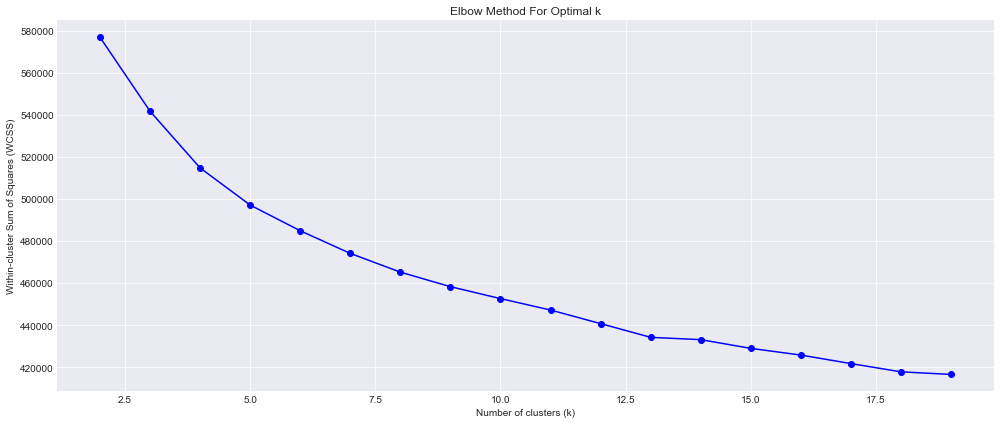

In [252]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(iran_bef)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [253]:
# Clustering with K-means
kmeans = KMeans(n_clusters=8, random_state=0)  # Assume we want 3 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(iran_bef['translated'].tolist(), clusters)


Cluster 0:
 - never truer word spoken realdonaldtrump rezaparchizadehlindseygrahamsc mdubowitz jschanzer doranimated iran
 - award stupidest tweet day goes good ole titi cate insinuating puerto ricans traitors usa getting paired iran 2019 fiba world cup 
 - help us reach 15000 crowdfund redresstrust provide nazanin zaghari ratcliffe legal support help us freenazanin comes harm vital continue put constant pressure uk iran set free  

Cluster 5:
 - us iran tensions continue escalate russia remains engaged covert overt cooperation iran ways undermine us national security interests  
 - happy country origin changing law adopted country morocco already single mother law directly impacts muslim world daughter live
 - irans rouhani warns macron looming nuclear step 

Cluster 3:
 - um didnt actually start trump tweet leaking classified military photographs iran 
 - sen dianne feinstein caught treasonous lie secret iran meeting turns sanctioned state dept 
 - yemen 10 millions step away famine

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### **North Korea**

In [34]:
nk_19_2 = countries[(countries['country']=="nk") & (countries['year'].isin([2019])) & (countries['month'].isin([8,9,10,11,12]))]
nk_20_1 = countries[(countries['country']=="nk") & (countries['year'].isin([2020])) & (countries['month'].isin([1,2,3]))]
nk_stb = pd.concat([nk_19_2], axis=0)
nk_19_1 = countries[(countries['country']=="nk") & (countries['year'].isin([2019])) & (countries['month'].isin([2,3,4,5,6]))]

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (1350, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

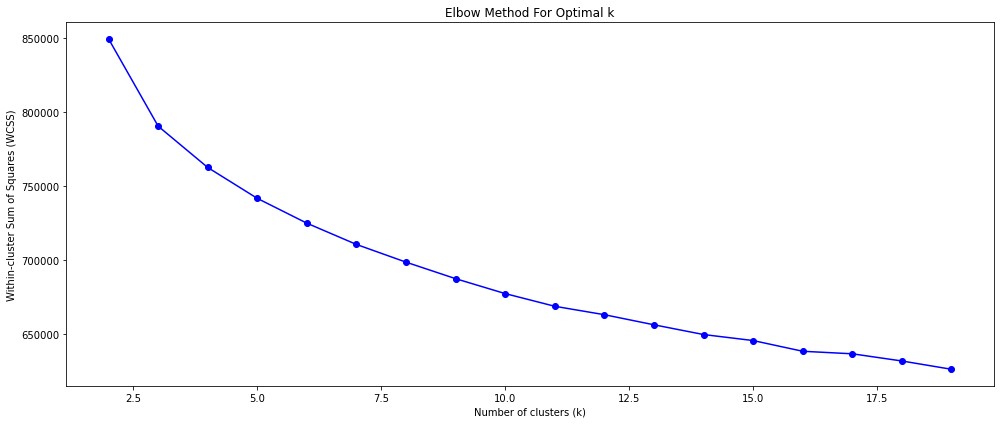

In [35]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(nk_stb)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [36]:
# Clustering with K-means
kmeans = KMeans(n_clusters=10, random_state=0)  # Assume we want 3 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(nk_stb['translated'].tolist(), clusters)


Cluster 5:
 - north korean underground church waiting regime change continued advance gospel 70 years teeth arguably worst persecution human history dr eric foley co founder leader vom korea 
 - trump increasingly displaying total disconnect reality claimed g 7 summit melania gotten know north korean leader despite two never met realdonaldtrump  via huffpostpol
 - tavleen singh even marxist text even mein kampf anyone explain book home north korean

Cluster 9:
 - trump openly condoned north korean short range missile tests new missiles threaten us japan south korea thanks north korean tests us bags 33 billion contract sell 73 sm 3 block iia anti ballistic missiles japan
 - thelastrefuge2 us blocking assets companies amp owners helped north korea circumvent un us restrictions import petroleum productstreasury designates shipping network engaged ship ship transfers north korean vessels
 - seoul south korea senior north korean diplomat saturday berated us secretary state mike pompeo comm

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (1197, 768)


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/c

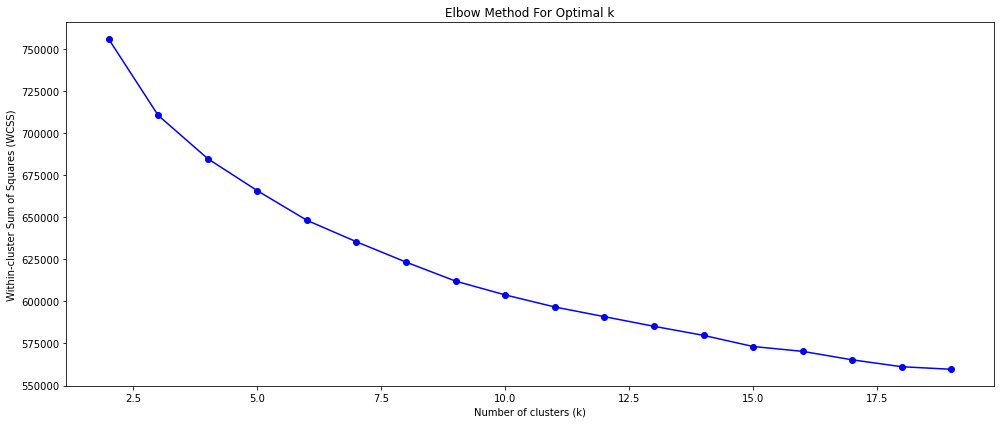

In [32]:
# Example call (change 'your_file_path.csv' to your actual file path)
embeddings = analyze_tweets(nk_19_1)

# Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# determine optimal number of clusters
create_sil_chart(embeddings)

In [33]:
# Clustering with K-means
kmeans = KMeans(n_clusters=10, random_state=0)  # Assume we want 3 clusters
clusters = kmeans.fit_predict(reduced_embeddings)
# Example usage
print_representative_docs(nk_19_1['translated'].tolist(), clusters)


Cluster 5:
 - moscow seeks carve role north korea nuclear negotiations two rossiya special flight squadron ilyushin il96 300 planes flying moscow vnukovo vladivostok knevichi putins entourage travelling putinkim summit 
 - kim jong un leader north korea arrives via train russia day ahead summit president vladimir putin  
 - kim jong un meet vladimir putin north korea pivots russia help

Cluster 2:
 - trump tweets something north korea actually something 
 - putinkimsummit approached kremlin portrayed north koreas stance denuclearization factcheck 
 - despite russias past vote favor sanctions kims regime moscow many reasons lean hard kim nuclear disarmament yangrikang breaks russian view north korea nukes time upcoming kim putin meeting  

Cluster 4:
 - iran north korea pursuing ability threaten us space systems primarily electronic cyber capabilities read csisaerospace space threat assessment 2019 learn iran north koreas counterspace capabilities  
 - iran sentence 100 interchangeable

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
